## Text Classification with Naive Bayes, Logistic Regression, and SVM

Let's start with importing the necessary modules and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\erkam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\erkam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erkam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Part I. Load and Explore the Dataset

In [3]:
df = pd.read_csv("../resources/text class/Full-Economic-News-DFE-839861.csv", encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [4]:
df.shape

(8000, 15)

In [5]:
df.relevance.value_counts(normalize=True)

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: proportion, dtype: float64

In [6]:
df = df[df.relevance != "not sure"]
df.shape

(7991, 15)

In [7]:
df.relevance = df.relevance.map({"yes":1, "no":0})
df.relevance.unique()

array([1, 0], dtype=int64)

### Part II. Text Pre-processing

Create a cleaner function for the textual features.

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tokenize_lemmatize(doc):
    doc = doc.lower()
    doc = doc.replace("</br>", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stop_words])

    tokens = word_tokenize(doc)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(tokens) 

In [9]:
df.text = df.text.apply(clean_tokenize_lemmatize)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,1,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,new york yield certificate deposit offered maj...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,0,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,wall street journal online morning brief look ...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,0,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,washington effort achieve banking reform senat...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,0,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,statistic enormous cost employee drug abuse we...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,1,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,new york indecision marked dollar tone trader ...


### Part III. Modeling

Split the dataset into testing and training sets.

In [10]:
x = df.text
y = df.relevance

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=58)

Vectorize the train and test sets.

In [11]:
vect = CountVectorizer(max_features=5000)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)

Train the Naive Bayes Classifier.

In [12]:
nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [13]:
print(classification_report(nb.predict(x_test_dtm), y_test))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1017
           1       0.69      0.35      0.46       582

    accuracy                           0.71      1599
   macro avg       0.70      0.63      0.63      1599
weighted avg       0.70      0.71      0.68      1599



Visualize the confusion matrix.

In [14]:
cm = confusion_matrix(nb.predict(x_test_dtm), y_test)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized

array([[0.90855457, 0.09144543],
       [0.64948454, 0.35051546]])

In [15]:
def plot_conf_matrix(cm):
    plt.clf()
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Irrelevant", "Relevant"], yticklabels=["Irrelevant", "Relevant"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

<Figure size 640x480 with 0 Axes>

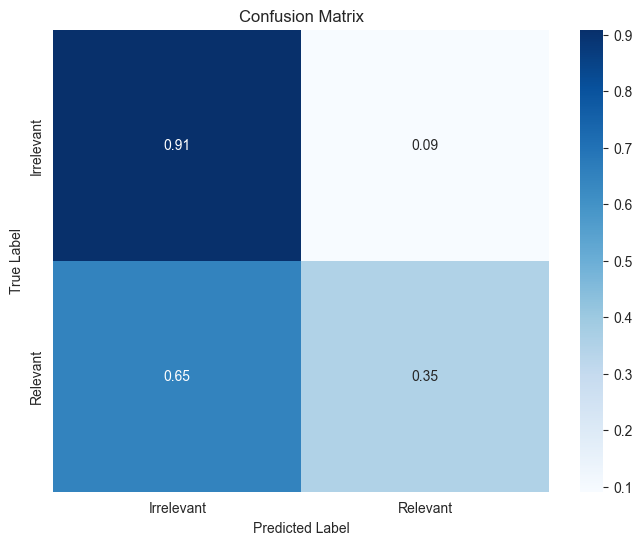

In [16]:
plot_conf_matrix(cm_normalized)

Now create a Logistic Regression model.

In [18]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(x_train_dtm, y_train)
print(classification_report(logreg.predict(x_test_dtm), y_test))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1216
           1       0.38      0.29      0.33       383

    accuracy                           0.71      1599
   macro avg       0.58      0.57      0.57      1599
weighted avg       0.69      0.71      0.70      1599



<Figure size 640x480 with 0 Axes>

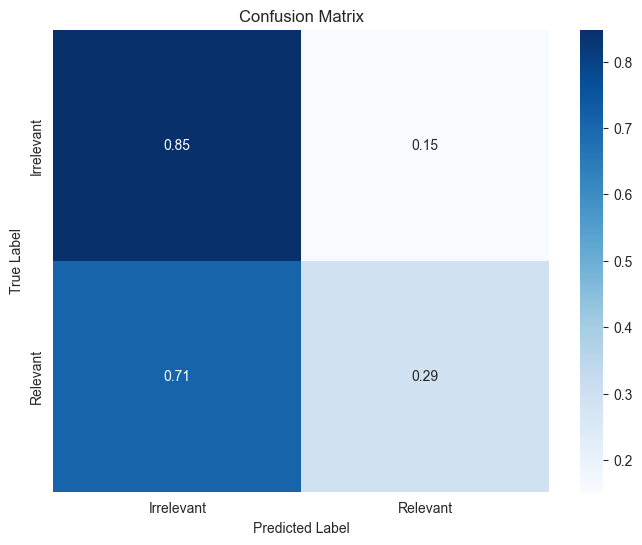

In [19]:
cm2 = confusion_matrix(logreg.predict(x_test_dtm), y_test)
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
plot_conf_matrix(cm2_normalized)

Lets try SVM.

In [20]:
vect = CountVectorizer(max_features=1000)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)

svm = LinearSVC(class_weight="balanced")
svm.fit(x_train_dtm, y_train)

y_pred = svm.predict(x_test_dtm)

<Figure size 640x480 with 0 Axes>

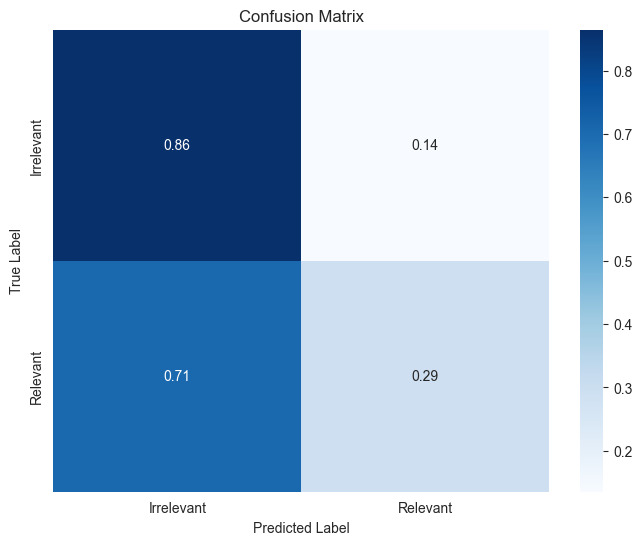

In [21]:
cm3 = confusion_matrix(svm.predict(x_test_dtm), y_test)
cm3_normalized = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
plot_conf_matrix(cm3_normalized)